### Optimize ACH with AutoGluon
---
- See example [here](https://github.com/aws/amazon-sagemaker-examples/tree/master/advanced_functionality/autogluon-tabular).
- [Quick Start](https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-quickstart.html)
- [In-Depth](https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-indepth.html#model-distillation)
- [Tabular-fit api](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.TabularPrediction.fit)

In [1]:
# !pip uninstall rdsutils --yes
# !pip install -i https://repository.sofi.com/artifactory/api/pypi/pypi/simple rdsutils --no-cache-dir

#### Installation

In [2]:
# !python3 -m pip install --upgrade pip
# !python3 -m pip install --upgrade "mxnet<2.0.0"
# !python3 -m pip install autogluon
# !pip install bokeh==2.0.1

#### Import modules

In [3]:
import os, sys
import pickle as pkl
import pandas as pd
import autogluon as ag
from autogluon import TabularPrediction as task

from rdsutils import datagen
from rdsutils import plot

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

#### Load and Clean data

In [4]:
modeling_df = pd.read_parquet('../../artifacts/20200920/modeling_df_w_baseline_preds.parquet')
modeling_df['account_ending_balance'] = modeling_df['real_ending_balance']
modeling_df['days_since_first_transaction'] = modeling_df['days_since_first_deposit']
modeling_df['ach_target'] = modeling_df['is_returned']

In [5]:
# get boruta features
fsel = pkl.load(open('../../artifacts/20200920/feature_selector_dict.pkl', 'rb'))
display(fsel.keys())
boruta_fimp = fsel['record_boruta_importance']
boruta_features = boruta_fimp[boruta_fimp.score>40].feature.to_list()

dict_keys(['features', 'label_cols', 'base_features', 'record_missing', 'record_single_unique', 'record_collinear', 'record_boruta_importance', 'record_iv', 'ops', 'woe', 'acceptable_corr_range', 'record_collinear_pairs', 'missing_threshold'])

In [6]:
# remove indeterminates


#### Train Test Split

In [9]:
modeling_dfs = datagen.GroupKFoldGenerator(modeling_df, 5, 
                              strategize_by='ach_target', 
                              groupby='business_account_number')
train, test = next(modeling_dfs)

In [10]:
modeling_dfs_ = datagen.GroupKFoldGenerator(train, 4, 
                              strategize_by='ach_target', 
                              groupby='business_account_number')
train, valid = next(modeling_dfs_)

In [11]:
train.shape, valid.shape, test.shape, modeling_df.shape

((67559, 177), (22520, 177), (22520, 177), (112599, 177))

#### Set AutoGluon Datasets

In [12]:
target_col = 'ach_target'
features = boruta_features
id_col = 'business_account_number'
pos_wgt_scaling_factor = datagen.get_positive_label_weight(train[target_col])

train_data = task.Dataset(df=train[features+[target_col]+[id_col]])
valid_data = task.Dataset(df=valid[features+[target_col]+[id_col]])
test_data = task.Dataset(df=test[features+[target_col]+[id_col]])

In [13]:
train_data.head()

,first_deposit_amount,vantage_score,ach_target,business_account_number
5859,100.0,NaN,False,410000070632
7761,10.0,NaN,False,410000070650
7784,10.0,NaN,False,410000070650
7789,10.0,NaN,False,410000070650
7796,10.0,NaN,False,410000070650


#### Train Models

`fit` documentations: [here](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.TabularPrediction.fit)

In [14]:
metric = 'f1'   # 'roc_auc', 'f1', 'average_precision'
path = '../../artifacts/autogluon-ach'
os.makedirs(path, exist_ok=True)


hp_tune = True
time_limits = 10*60  # 2mins
cat_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'l2_leaf_reg': ag.space.Real(lower=0, upper=20, default=5),
    'min_data_in_leaf': ag.space.Int(lower=10, upper=50, default=30),
    'depth' : ag.space.Int(lower=2, upper=5, default=3),
    'learning_rate': ag.space.Real(1e-3, 1e-1, default=1e-2),
    'bagging_temperature' : ag.space.Real(0, 100, default=0.5),
    'scale_pos_weight': pos_wgt_scaling_factor,
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_leaves' : ag.space.Int(lower=5, upper=20, default=10),
    'lambda_l1': ag.space.Real(lower=0, upper=20, default=5),
    'lambda_l2': ag.space.Real(lower=0, upper=20, default=5),
    'min_data_in_leaf': ag.space.Int(lower=10, upper=50, default=30),
    'max_depth' : ag.space.Int(lower=2, upper=5, default=3),
    'num_boost_round': ag.space.Int(lower=100, upper=2000, default=500),
    'learning_rate': ag.space.Real(1e-3, 1e-1, default=1e-2),
    'feature_fraction' : ag.space.Real(0.1, 0.8, default=0.5),
    'scale_pos_weight': pos_wgt_scaling_factor,
}

predictor = task.fit(train_data=train_data, 
                     tuning_data=valid_data,
                     label=target_col, 
                     output_directory=path, 
                     eval_metric=metric,
                     time_limits=time_limits,
                     hyperparameter_tune=hp_tune,
                     hyperparameters={'CAT':cat_options,
                                      'GBM':gbm_options},
                     search_strategy='skopt')

Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to ../../artifacts/autogluon-ach/
AutoGluon Version:  0.0.14
Train Data Rows:    67559
Train Data Columns: 3
Tuning Data Rows:    22520
Tuning Data Columns: 3
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [False, True]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    60277.73 MB
	Train Data (Original)  Memory Usage: 2.16 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the 

Time out (secs) is 270.0
	Ran out of time, early stopping on iteration 37. Best iteration is:
	[7]	train_set's binary_logloss: 0.238279	train_set's f1: 0.446898	valid_set's binary_logloss: 0.233729	valid_set's f1: 0.479735


	0.4666	 = Validation f1 score
	12.02s	 = Training runtime
	0.01s	 = Validation runtime
	0.4808	 = Validation f1 score
	7.99s	 = Training runtime
	0.0s	 = Validation runtime
	0.4748	 = Validation f1 score
	9.16s	 = Training runtime
	0.01s	 = Validation runtime
	0.4797	 = Validation f1 score
	7.9s	 = Training runtime
	0.01s	 = Validation runtime
	0.4665	 = Validation f1 score
	11.25s	 = Training runtime
	0.01s	 = Validation runtime
	0.4806	 = Validation f1 score
	8.39s	 = Training runtime
	0.01s	 = Validation runtime
	0.4817	 = Validation f1 score
	8.11s	 = Training runtime
	0.01s	 = Validation runtime
	0.0	 = Validation f1 score
	5.11s	 = Training runtime
	0.0s	 = Validation runtime
	0.46	 = Validation f1 score
	7.85s	 = Training runtime
	0.0s	 = Validation runtime
	0.4801	 = Validation f1 score
	7.64s	 = Training runtime
	0.0s	 = Validation runtime
	0.4797	 = Validation f1 score
	7.96s	 = Training runtime
	0.0s	 = Validation runtime
	0.4801	 = Validation f1 score
	7.58s	 = Training ru

Time out (secs) is 270.0
used random search instead of skopt to produce new hyperparameter configuration in this trial
used random search instead of skopt to produce new hyperparameter configuration in this trial
used random search instead of skopt to produce new hyperparameter configuration in this trial
used random search instead of skopt to produce new hyperparameter configuration in this trial
used random search instead of skopt to produce new hyperparameter configuration in this trial
used random search instead of skopt to produce new hyperparameter configuration in this trial
used random search instead of skopt to produce new hyperparameter configuration in this trial


	0.2458	 = Validation f1 score
	0.95s	 = Training runtime
	0.0s	 = Validation runtime
	0.2485	 = Validation f1 score
	0.72s	 = Training runtime
	0.0s	 = Validation runtime
	0.2423	 = Validation f1 score
	0.66s	 = Training runtime
	0.0s	 = Validation runtime
	0.2199	 = Validation f1 score
	0.59s	 = Training runtime
	0.0s	 = Validation runtime
	0.2408	 = Validation f1 score
	0.69s	 = Training runtime
	0.0s	 = Validation runtime
	0.2536	 = Validation f1 score
	0.79s	 = Training runtime
	0.0s	 = Validation runtime
	0.2455	 = Validation f1 score
	0.88s	 = Training runtime
	0.0s	 = Validation runtime
	0.2583	 = Validation f1 score
	1.15s	 = Training runtime
	0.0s	 = Validation runtime
	0.2168	 = Validation f1 score
	0.66s	 = Training runtime
	0.0s	 = Validation runtime
	0.2373	 = Validation f1 score
	0.77s	 = Training runtime
	0.0s	 = Validation runtime
	0.2181	 = Validation f1 score
	0.8s	 = Training runtime
	0.0s	 = Validation runtime
	0.2538	 = Validation f1 score
	1.05s	 = Training runti

In [15]:
try:
    y_true = test_data[target_col]
    test_data = test_data.drop(labels=[target_col], axis=1)
except:
    pass
test_data.head()

,first_deposit_amount,vantage_score,business_account_number
12804,5.00,NaN,410000070984
14332,0.47,NaN,410000071044
14340,0.47,NaN,410000071044
15690,20.00,NaN,410000071129
15717,20.00,NaN,410000071129


In [16]:
predictor = task.load(path)
y_pred = predictor.predict(test_data)
perf = predictor.evaluate_predictions(y_true=y_true, y_pred=y_pred, auxiliary_metrics=True, )

Evaluation: f1 on test data: 0.4606557377049181
Evaluations on test data:
{
    "f1": 0.4606557377049181,
    "accuracy_score": 0.9707815275310835,
    "balanced_accuracy_score": 0.675643670239535,
    "matthews_corrcoef": 0.4673349156504239,
    "f1_score": 0.9707815275310835
}
Detailed (per-class) classification report:
{
    "False": {
        "precision": 0.9772233291070458,
        "recall": 0.9928689731321311,
        "f1-score": 0.9849840255591054,
        "support": 21736
    },
    "True": {
        "precision": 0.6444954128440367,
        "recall": 0.35841836734693877,
        "f1-score": 0.4606557377049181,
        "support": 784
    },
    "accuracy": 0.9707815275310835,
    "macro avg": {
        "precision": 0.8108593709755412,
        "recall": 0.675643670239535,
        "f1-score": 0.7228198816320117,
        "support": 22520
    },
    "weighted avg": {
        "precision": 0.965639906089719,
        "recall": 0.9707815275310835,
        "f1-score": 0.9667303231755493,

In [17]:
model = None  # 'LightGBMClassifier', 'CatboostClassifier', 'weighted_ensemble_k0_l1'
predictor = task.load(path)
y_pred = predictor.predict_proba(test_data, model=model)
test['autogluon_untuned_pred'] = y_pred

*** Summary of fit() ***
Estimated performance of each model:
                            model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         weighted_ensemble_k0_l1   0.491409       0.053161  27.201848                0.042704          11.102202            1       True        109
1      LightGBMClassifier/trial_2   0.489619       0.004532   7.956147                0.004532           7.956147            0       True         13
2      LightGBMClassifier/trial_8   0.482759       0.004411   8.046947                0.004411           8.046947            0       True         27
3     LightGBMClassifier/trial_14   0.481685       0.005566   8.112255                0.005566           8.112255            0       True          7
4      LightGBMClassifier/trial_6   0.481244       0.005925   8.143499                0.005925           8.143499            0       True         25
5      LightGBMClassifier/trial_1   0.480804

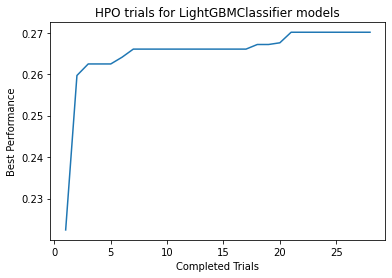

Plot summary of models saved to file: ../../artifacts/autogluon-ach/CatboostClassifier_HPOmodelsummary.html
Plot summary of models saved to file: CatboostClassifier_HPOmodelsummary.html
Plot of HPO performance saved to file: ../../artifacts/autogluon-ach/CatboostClassifier_HPOperformanceVStrials.png


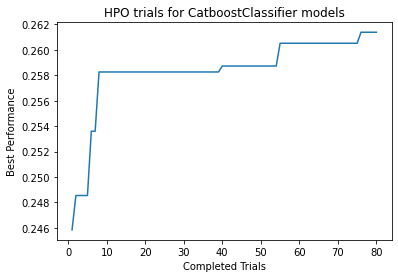

*** Details of Hyperparameter optimization ***
HPO for LightGBMClassifier model:  Num. configurations tried = 28, Time spent = 272.38644528388977s, Search strategy = skopt
Best hyperparameter-configuration (validation-performance: f1 = 0.27011630666983144):
{'feature_fraction': 0.361955253584467, 'lambda_l1': 17.620997660991137, 'lambda_l2': 6.817153595130293, 'learning_rate': 0.09432285091125954, 'max_depth': 3, 'min_data_in_leaf': 41, 'num_boost_round': 1759, 'num_leaves': 11}
HPO for CatboostClassifier model:  Num. configurations tried = 80, Time spent = 271.66373658180237s, Search strategy = skopt
Best hyperparameter-configuration (validation-performance: f1 = 0.26138876603272887):
{'bagging_temperature': 0.0, 'depth': 4, 'l2_leaf_reg': 0.0, 'learning_rate': 0.1, 'min_data_in_leaf': 50}
*** End of fit() summary ***


In [18]:
predictor.fit_summary();

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='Recall', ylabel='Precision'>)

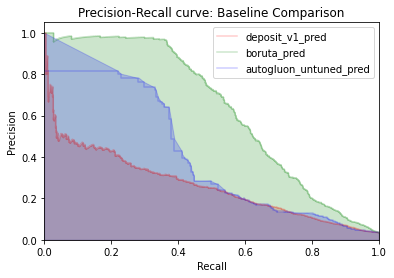

In [21]:
preds = [(test['deposit_v1_pred'], 'deposit_v1_pred'), 
         (test['boruta_pred'], 'boruta_pred'), 
         (test['autogluon_untuned_pred'], 'autogluon_untuned_pred')]
title = 'Precision-Recall curve: Baseline Comparison'
plot.plot_pr_curve_mult(test[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

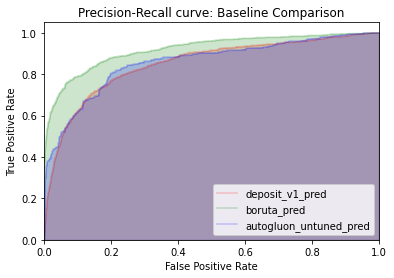

In [22]:
plot.plot_auc_curve_mult(test[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])